# Chicago Crime - Spatial Pattern Analysis

This notebook performs **spatial pattern analysis** on Chicago crime data, covering all recommended chart types:

| Analysis Type | Chart |
|--------------|-------|
| Overall Distribution | Scatter Plot ✓ |
| Distribution by Crime Type | Scatter Plot ✓ |
| Crime Density | Heat Map ✓ |
| Community Area Analysis | Bar Chart ✓ |
| Temporal-Spatial Pattern | Scatter Plot ✓ |

## 1. Environment Setup and Data Loading

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from pathlib import Path

# Plot styling
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Data path
DATA_PATH = Path("../data/processed/chicago_crimes_2015_2024_cleaned.csv")

df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])

# Keep only records with valid coordinates
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2477275 entries, 0 to 2477274
Data columns (total 13 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[us]
 1   primary_type          str           
 2   description           str           
 3   location_description  str           
 4   arrest                bool          
 5   domestic              bool          
 6   beat                  int64         
 7   district              float64       
 8   ward                  float64       
 9   community_area        float64       
 10  year                  int64         
 11  latitude              float64       
 12  longitude             float64       
dtypes: bool(2), datetime64[us](1), float64(5), int64(2), str(3)
memory usage: 212.6 MB


## 2. Data Cleaning and Validation

In [29]:
# Check coordinate statistics
df = df.dropna(subset=["latitude", "longitude"])
print("Coordinate Statistics:")
print(df[["latitude", "longitude"]].describe())

# Filter valid Chicago coordinates (latitude ~41.8, longitude ~-87.6)
# Remove outliers outside reasonable Chicago bounds
df = df[(df["latitude"] > 37) & (df["latitude"] < 42) & 
        (df["longitude"] > -91) & (df["longitude"] < -87)]

df = df.reset_index(drop=True)
df.info()

Coordinate Statistics:
           latitude     longitude
count  2.477275e+06  2.477275e+06
mean   4.184412e+01 -8.767008e+01
std    8.680807e-02  5.949322e-02
min    3.661945e+01 -9.168657e+01
25%    4.176891e+01 -8.771241e+01
50%    4.186253e+01 -8.766362e+01
75%    4.190681e+01 -8.762762e+01
max    4.202267e+01 -8.752453e+01
<class 'pandas.DataFrame'>
RangeIndex: 2425599 entries, 0 to 2425598
Data columns (total 13 columns):
 #   Column                Dtype         
---  ------                -----         
 0   date                  datetime64[us]
 1   primary_type          str           
 2   description           str           
 3   location_description  str           
 4   arrest                bool          
 5   domestic              bool          
 6   beat                  int64         
 7   district              float64       
 8   ward                  float64       
 9   community_area        float64       
 10  year                  int64         
 11  latitude          

## 3. Overall Spatial Distribution (Scatter Plot)

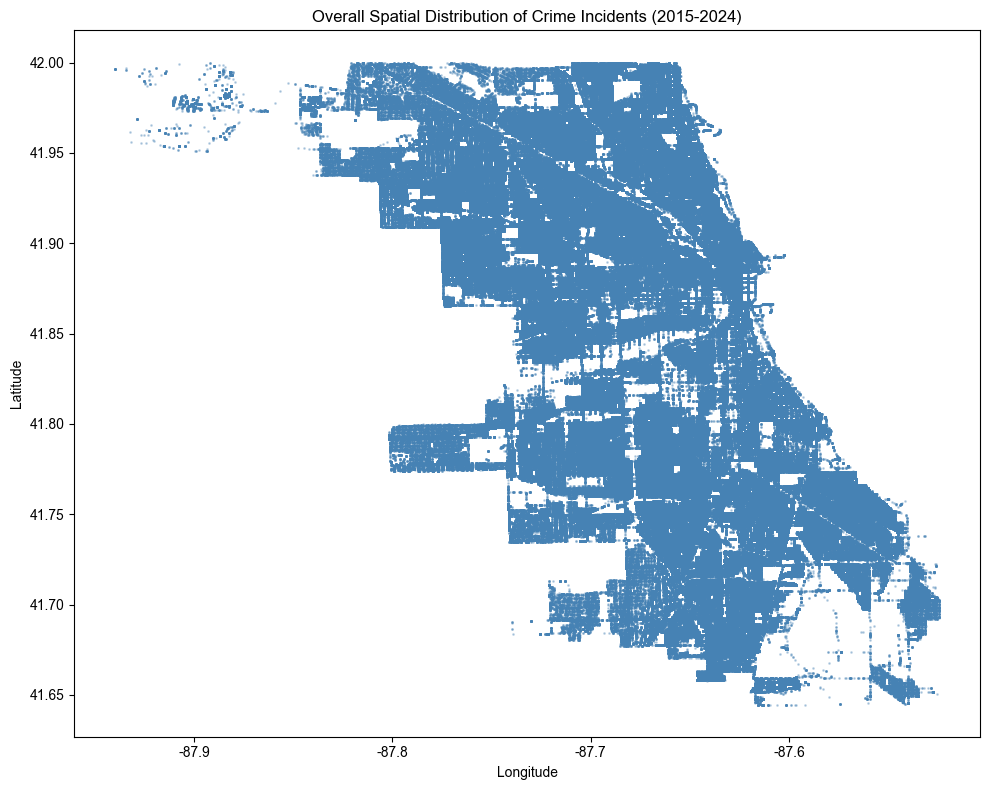

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(df["longitude"], df["latitude"], s=1, alpha=0.3, color='steelblue')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Overall Spatial Distribution of Crime Incidents (2015-2024)")
plt.tight_layout()
plt.show()


## 4. Spatial Distribution by Crime Type (Scatter Plot)

Using 5,000 records for visualization


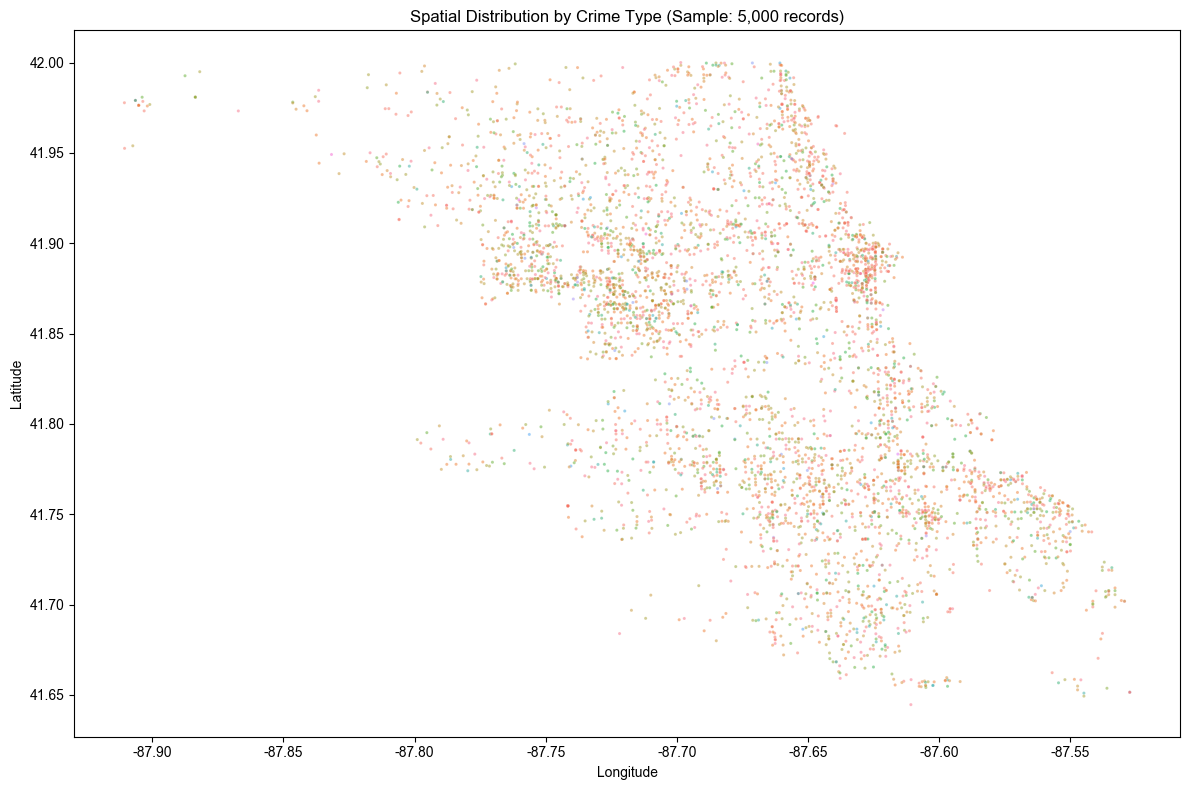

In [31]:
# Sample data for visualization
sample_size = 5000
sample_df = df.sample(n=min(sample_size, len(df)), random_state=42)
print(f"Using {len(sample_df):,} records for visualization")

fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(
    data=sample_df,
    x="longitude",
    y="latitude",
    hue="primary_type",
    s=5,
    alpha=0.5,
    legend=False
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Spatial Distribution by Crime Type (Sample: 5,000 records)")
plt.tight_layout()
plt.show()


## 5. Crime Density Heat Map

In [ ]:
# Create interactive density heat map using Plotly 
df_map = df[["latitude", "longitude"]].dropna()

# Sample data if too large
if len(df_map) > 250000:
    df_map = df_map.sample(250000, random_state=42)
    print(f"Sampled {len(df_map):,} records for visualization")
else:
    print(f"Using {len(df_map):,} records for visualization")

# Grid binning 
cell = 0.004
df_map["lat_bin"] = (df_map["latitude"] / cell).round() * cell
df_map["lon_bin"] = (df_map["longitude"] / cell).round() * cell

# Aggregate by grid cells
grid = df_map.groupby(["lat_bin", "lon_bin"]).size().reset_index(name="count")

# Calculate vmax using 98th percentile
vmax = int(grid["count"].quantile(0.98))
vmax = max(vmax, 1)

print(f"Grid cells: {len(grid):,}, Max count per cell: {grid['count'].max()}, vmax: {vmax}")

# Create density mapbox 
fig_den = px.density_mapbox(
    grid,
    lat="lat_bin",
    lon="lon_bin",
    z="count",
    radius=18,
    zoom=9.8,
    center={"lat": 41.8781, "lon": -87.6298},
    mapbox_style="open-street-map",
    color_continuous_scale="Turbo",
    range_color=[0, vmax],
    opacity=0.8,
    hover_data={"lat_bin": ":.4f", "lon_bin": ":.4f", "count": True},
)

fig_den.update_layout(
    height=750,
    margin=dict(l=0, r=0, t=30, b=0),
    coloraxis_colorbar=dict(title="Count per grid cell"),
)

# Display the map
fig_den.show()

# Save map
os.makedirs("output", exist_ok=True)
output_path = "output/crime_heatmap.html"
fig_den.write_html(output_path)
print(f"Heat map saved to: {output_path}")

Sampled 250,000 records for visualization
Grid cells: 3,606, Max count per cell: 1715, vmax: 291


/var/folders/td/c5bzm04n4zg3th6bngrj9wsm0000gn/T/ipykernel_5226/4180861631.py:26: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Heat map saved to: output/crime_heatmap.html


## 6. Community Area Analysis (Bar Chart)

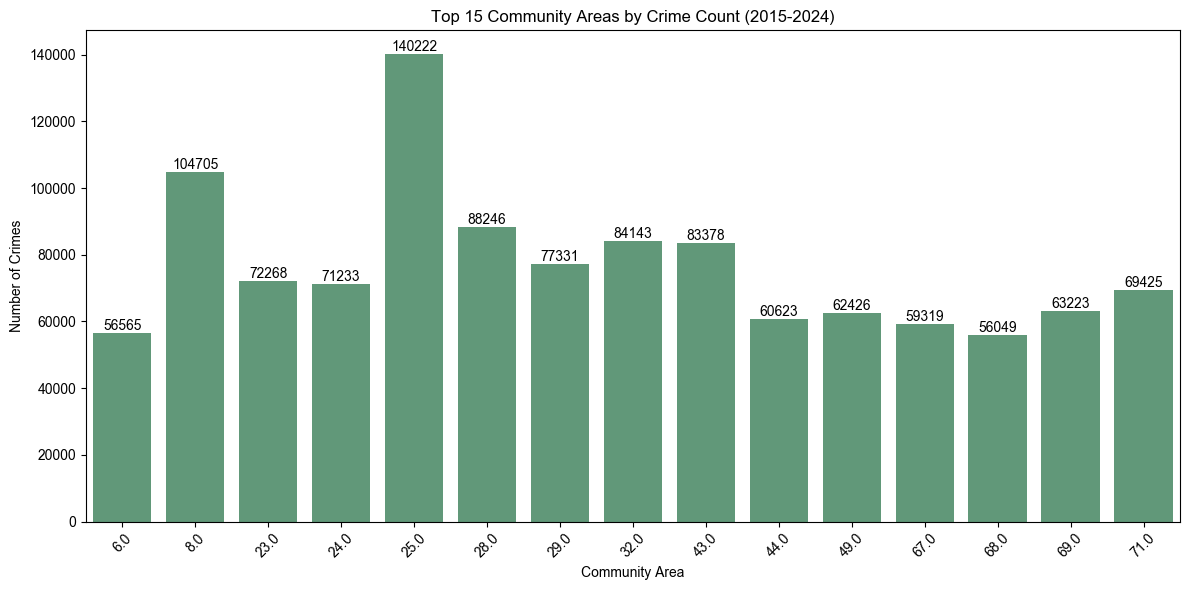

In [33]:
crime_by_area = (
    df["community_area"]
    .value_counts()
    .head(15)
)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x=crime_by_area.index,
    y=crime_by_area.values,
    color='seagreen',
    alpha=0.8
)
ax.bar_label(ax.containers[0])
ax.set_xlabel("Community Area")
ax.set_ylabel("Number of Crimes")
ax.set_title("Top 15 Community Areas by Crime Count (2015-2024)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 7. Temporal-Spatial Pattern (Scatter Plot by Year)

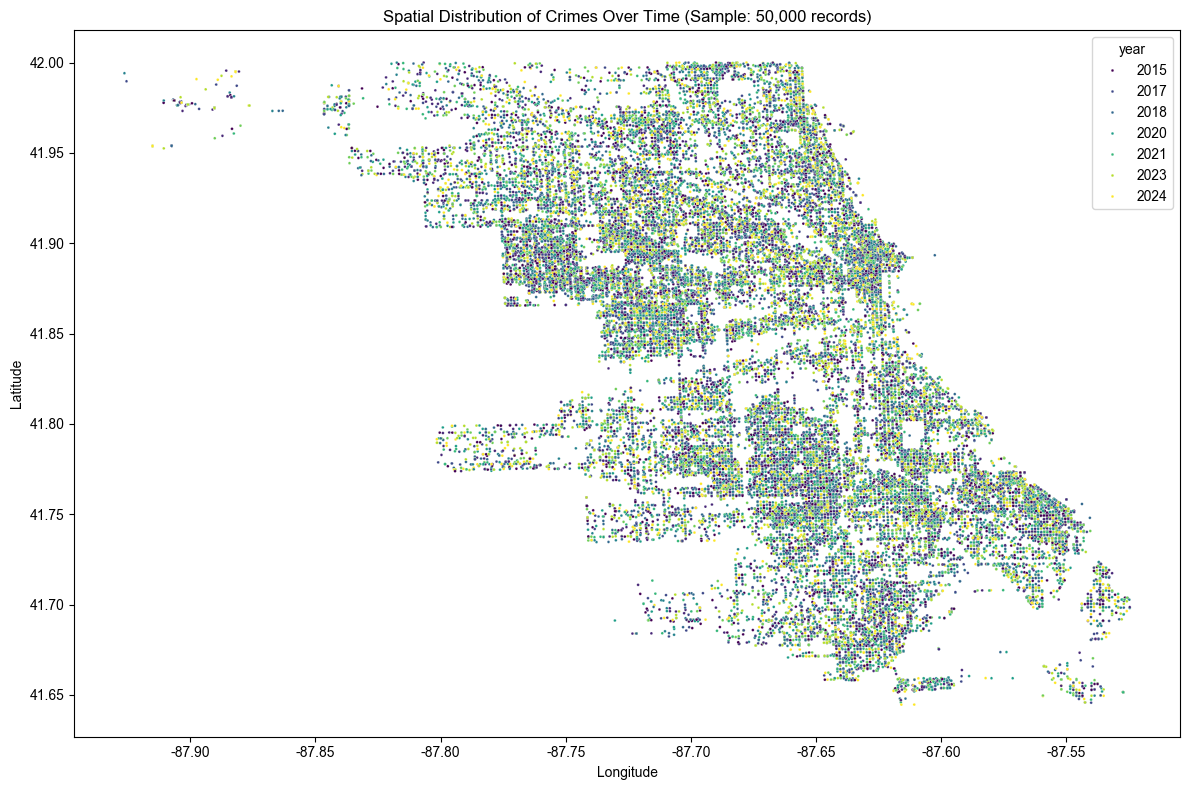

In [34]:
# Extract year if not already present
if 'year' not in df.columns:
    df['year'] = df['date'].dt.year

# Sample for visualization
sample = df.sample(50000, random_state=42)

fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(
    data=sample,
    x="longitude",
    y="latitude",
    hue="year",
    palette="viridis",
    s=4,
    legend=True
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Spatial Distribution of Crimes Over Time (Sample: 50,000 records)")
plt.tight_layout()
plt.show()